## Claustrophobic Streets
Work by Matt Franchi


### Notebook Description: 
In this notebook, we aggregate the computed traffic and space together, producing a metric for 'claustrophobia'. Note, this metric is not rigorously validated, as ground truth here is extremely difficult to ascertain (and in fact, somewhat rooted in opinion.)

### Performance Notes: 
We run this notebook on a compute node with 64GB RAM and 8 CPUs. 




In [5]:
import pandas as pd 
import geopandas as gpd 
from shapely import wkt

import matplotlib.pyplot as plt 

from tqdm import tqdm 
from glob import glob 

import logging 
# add logger name, time and date to log messages
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
log = logging.getLogger("aggregation")


log.info("Initialization complete.")

2025-04-15 11:23:13,477 - aggregation - INFO - Initialization complete.


In [31]:
PROJ_CRS = 'EPSG:2263'
DESIRED_SPACE_BETWEEN_PEDS = 6

<Axes: >

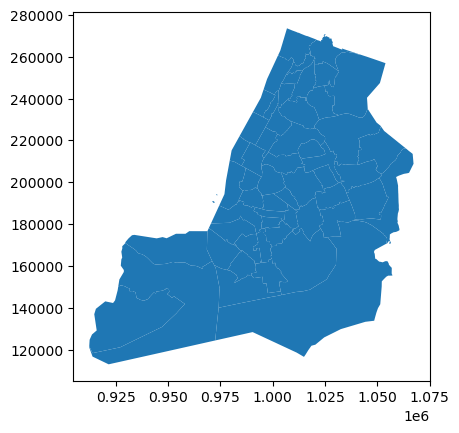

In [7]:
pumas_nyc = gpd.read_file("../data/nyc/sf/tl_2022_36_puma20/tl_2022_36_puma20.shp").to_crs(PROJ_CRS)
pumas_nyc = pumas_nyc[pumas_nyc['NAMELSAD20'].str.contains('NYC')]
pumas_nyc.plot()

In [8]:
dp05 = pd.read_csv("../data/nyc/sf/ACSDP1Y2023.DP05-2024-09-24T165218.csv", index_col=0)
dp05 = dp05[dp05.columns[dp05.columns.str.contains('NYC')].tolist()]
dp05 


,NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA; New York!!Estimate,NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA; New York!!Margin of Error,NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA; New York!!Percent,NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA; New York!!Percent Margin of Error,NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA; New York!!Estimate,NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA; New York!!Margin of Error,NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA; New York!!Percent,NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA; New York!!Percent Margin of Error,NYC-Manhattan Community District 7--Upper West Side PUMA; New York!!Estimate,NYC-Manhattan Community District 7--Upper West Side PUMA; New York!!Margin of Error,...,NYC-Staten Island Community District 1--North Shore PUMA; New York!!Percent,NYC-Staten Island Community District 1--North Shore PUMA; New York!!Percent Margin of Error,NYC-Staten Island Community District 2--Mid-Island PUMA; New York!!Estimate,NYC-Staten Island Community District 2--Mid-Island PUMA; New York!!Margin of Error,NYC-Staten Island Community District 2--Mid-Island PUMA; New York!!Percent,NYC-Staten Island Community District 2--Mid-Island PUMA; New York!!Percent Margin of Error,NYC-Staten Island Community District 3--South Shore PUMA; New York!!Estimate,NYC-Staten Island Community District 3--South Shore PUMA; New York!!Margin of Error,NYC-Staten Island Community District 3--South Shore PUMA; New York!!Percent,NYC-Staten Island Community District 3--South Shore PUMA; New York!!Percent Margin of Error
Label (Grouping),,,,,,,,,,,,,,,,,,,,,
SEX AND AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total population,"148,789","±13,410","148,789",(X),"121,493","±10,313","121,493",(X),"224,282","±17,289",...,"167,916",(X),"142,150","±10,116","142,150",(X),"180,621","±10,741","180,621",(X)
Male,"72,563","±7,615",48.8%,±2.5,"64,009","±5,844",52.7%,±2.8,"106,924","±10,291",...,48.6%,±1.4,"70,120","±6,115",49.3%,±1.6,"88,459","±5,882",49.0%,±1.3
Female,"76,226","±7,674",51.2%,±2.5,"57,484","±6,464",47.3%,±2.8,"117,358","±9,527",...,51.4%,±1.4,"72,030","±4,892",50.7%,±1.6,"92,162","±5,800",51.0%,±1.3
Sex ratio (males per 100 females),95.2,±9.5,(X),(X),111.4,±12.6,(X),(X),91.1,±8.0,...,(X),(X),97.3,±6.2,(X),(X),96.0,±4.9,(X),(X)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total housing units,"81,524","±5,794",(X),(X),"77,155","±5,129",(X),(X),"130,224","±7,059",...,(X),(X),"51,472","±2,982",(X),(X),"64,841","±3,117",(X),(X)
"CITIZEN, VOTING AGE POPULATION",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Citizen, 18 and over population","111,962","±9,657","111,962",(X),"94,442","±8,325","94,442",(X),"158,461","±10,844",...,"113,432",(X),"103,053","±7,391","103,053",(X),"131,628","±7,815","131,628",(X)


In [9]:
# disability 
s1810 = pd.read_csv("../data/nyc/sf/ACSST1Y2023.S1810-2024-09-24T170627.csv", index_col=0)
s1810 = s1810[s1810.columns[s1810.columns.str.contains('NYC')].tolist()]
s1810.index = s1810.index.str.replace('\xa0','')

# drop all columns with 'Margin of Error' in the name
s1810 = s1810[s1810.columns[~s1810.columns.str.contains('Margin of Error')].tolist()]

s1810

# keep columns with 'With a disability' in the name as a separate df, called s1810_disability 
# keep the rest under a separate df called s1810_total 

s1810_disability = s1810[s1810.columns[s1810.columns.str.contains('With a disability')].tolist()]
s1810_total = s1810[s1810.columns[s1810.columns.str.contains('Total')].tolist()]




In [10]:
# parse out everything after semicolon in the column names 
import numpy as np 
s1810_disability.columns = s1810_disability.columns.str.split(';').map(lambda x: x[0])
s1810_disability = s1810_disability.map(lambda x: int(x.strip().replace(',','').replace('±','').strip().replace('NaN', '-1').replace('N','-1')) if isinstance(x, str) else x)
# drop na rows 
s1810_disability = s1810_disability.dropna().T

# drop columns with -1
#s1810_disability = s1810_disability.loc[:, (s1810_disability != -1).all()]

s1810_disability.describe()





Label (Grouping),Total civilian noninstitutionalized population,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,...,Population 65 years and over,Population 65 to 74 years,Population 75 years and over,With an independent living difficulty,Population 18 to 64 years,Population 18 to 34 years,Population 35 to 64 years,Population 65 years and over,Population 65 to 74 years,Population 75 years and over
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,55.000000,55.0,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,19212.418182,8346.545455,10865.872727,5722.854545,4990.709091,-1.0,2091.690909,-1.0,3318.181818,2594.527273,...,2987.272727,871.254545,2116.018182,8007.363636,3122.527273,676.290909,2446.236364,4884.836364,1605.763636,3279.072727
std,6704.798286,2921.188227,3996.016781,3985.470442,4837.351830,0.0,2553.493793,0.0,3463.031364,2036.849309,...,1400.416293,517.293928,1200.880533,3159.089985,1817.678718,484.374881,1582.584489,2088.786532,811.181259,1607.243509
min,6362.000000,2971.000000,3391.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,437.000000,...,510.000000,0.000000,510.000000,1818.000000,661.000000,32.000000,266.000000,1157.000000,0.000000,656.000000
25%,14733.000000,6173.500000,8440.500000,2786.000000,858.000000,-1.0,599.000000,-1.0,932.000000,1379.500000,...,2067.000000,486.500000,1436.000000,5706.000000,1961.000000,356.500000,1403.500000,3620.000000,1002.500000,2247.000000
50%,18326.000000,8048.000000,10058.000000,4548.000000,3260.000000,-1.0,1267.000000,-1.0,1800.000000,2117.000000,...,2703.000000,870.000000,1933.000000,7176.000000,2784.000000,499.000000,2081.000000,4546.000000,1435.000000,2889.000000
75%,22770.500000,9707.500000,12398.000000,8204.500000,8886.000000,-1.0,3024.500000,-1.0,4631.500000,2932.500000,...,3588.000000,1285.500000,2480.500000,9568.500000,3756.500000,1020.000000,3139.000000,5394.500000,2342.500000,3776.000000
max,41559.000000,17716.000000,23843.000000,15493.000000,15098.000000,-1.0,15855.000000,-1.0,14049.000000,11845.000000,...,9029.000000,1872.000000,7813.000000,16006.000000,8648.000000,2510.000000,7198.000000,12921.000000,3431.000000,10315.000000


In [11]:
# parse out everything after semicolon in column names 
s1810_total.columns = s1810_total.columns.str.split(';').str[0]
s1810_total = s1810_total.map(lambda x: int(x.strip().replace(',','').replace('±','').strip().replace('NaN', '-1').replace('N','-1').replace('(X)','-1')) if isinstance(x, str) else x)
# drop na rows
s1810_total = s1810_total.dropna()
s1810_total = s1810_total.T

s1810_total.describe() 




Label (Grouping),Total civilian noninstitutionalized population,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,Two or more races,...,Population 65 years and over,Population 65 to 74 years,Population 75 years and over,With an independent living difficulty,Population 18 to 64 years,Population 18 to 34 years,Population 35 to 64 years,Population 65 years and over,Population 65 to 74 years,Population 75 years and over
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.0,55.000000,55.0,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,149166.236364,71482.727273,77683.509091,50008.272727,31921.454545,-1.0,21537.181818,-1.0,23350.763636,18671.763636,...,25362.381818,14478.818182,10883.563636,-1.0,94108.818182,36815.509091,57293.309091,25362.381818,14478.818182,10883.563636
std,37801.471569,18804.313698,19572.032003,39739.337462,33954.003288,0.0,22669.457468,0.0,19041.264200,6720.136760,...,9244.458143,4972.553871,4679.651074,0.0,24342.988006,12592.349394,14958.113483,9244.458143,4972.553871,4679.651074
min,94609.000000,40047.000000,48683.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.000000,6329.000000,...,10657.000000,6808.000000,2959.000000,-1.0,51410.000000,18417.000000,32987.000000,10657.000000,6808.000000,2959.000000
25%,119382.000000,57181.000000,61451.000000,23646.000000,7311.000000,-1.0,3707.500000,-1.0,8035.500000,14671.500000,...,18933.500000,10506.500000,7858.500000,-1.0,75376.000000,28435.000000,48594.000000,18933.500000,10506.500000,7858.500000
50%,140952.000000,69271.000000,73034.000000,38490.000000,19452.000000,-1.0,17699.000000,-1.0,19395.000000,17741.000000,...,25292.000000,13833.000000,10406.000000,-1.0,91899.000000,34495.000000,54722.000000,25292.000000,13833.000000,10406.000000
75%,176966.500000,84817.500000,91512.000000,63868.500000,48257.500000,-1.0,32052.000000,-1.0,31152.000000,22056.000000,...,29603.000000,16587.500000,12304.000000,-1.0,108028.000000,42302.000000,64643.000000,29603.000000,16587.500000,12304.000000
max,241946.000000,115935.000000,128426.000000,144567.000000,137043.000000,-1.0,131982.000000,-1.0,71907.000000,39515.000000,...,52218.000000,28319.000000,26101.000000,-1.0,151390.000000,81090.000000,100289.000000,52218.000000,28319.000000,26101.000000


In [12]:
s1810_disability.columns
VISION_DIFFICULTY = 'With a vision difficulty'
AMBULATORY_DIFFICULTY = 'With an ambulatory difficulty'

with_disability_distribution = s1810_disability[[VISION_DIFFICULTY, AMBULATORY_DIFFICULTY]]
with_disability_distribution.describe()

Label (Grouping),With a vision difficulty,With an ambulatory difficulty
count,55.000000,55.000000
mean,4449.272727,11262.272727
std,3130.570522,4266.621330
min,771.000000,2470.000000
25%,2470.500000,8526.000000
50%,3711.000000,11099.000000
75%,5320.000000,12953.000000
max,18923.000000,21962.000000


In [13]:


UNDER_5 = 'Under 5 years'
AGE_5_TO_17 = '5 to 17 years'
AGE_18_TO_34 = '18 to 34 years'
AGE_35_TO_64 = '35 to 64 years'
AGE_65_TO_74 = '65 to 74 years'
AGE_75_PLUS = '75 years and over'
TOTAL = 'Total civilian noninstitutionalized population'

age_distribution = s1810_total[[UNDER_5, AGE_5_TO_17, AGE_18_TO_34, AGE_35_TO_64, AGE_65_TO_74, AGE_75_PLUS, TOTAL]]
age_distribution.describe()

Label (Grouping),Under 5 years,5 to 17 years,18 to 34 years,35 to 64 years,65 to 74 years,75 years and over,Total civilian noninstitutionalized population
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,8101.163636,21593.872727,36815.509091,57293.309091,14478.818182,10883.563636,149166.236364
std,3343.280457,8507.653922,12592.349394,14958.113483,4972.553871,4679.651074,37801.471569
min,2209.000000,6843.000000,18417.000000,32987.000000,6808.000000,2959.000000,94609.000000
25%,5949.000000,16076.500000,28435.000000,48594.000000,10506.500000,7858.500000,119382.000000
50%,7663.000000,20146.000000,34495.000000,54722.000000,13833.000000,10406.000000,140952.000000
75%,9625.500000,25641.000000,42302.000000,64643.000000,16587.500000,12304.000000,176966.500000
max,21111.000000,50438.000000,81090.000000,100289.000000,28319.000000,26101.000000,241946.000000


In [14]:
# now, combine 
population = pd.concat([with_disability_distribution, age_distribution], axis=1)


population['child'] = population[UNDER_5] + population[AGE_5_TO_17]
population['older'] = population[AGE_65_TO_74] + population[AGE_75_PLUS]
population['no_qualifiers'] = population[AGE_18_TO_34] + population[AGE_35_TO_64]
population['blind'] = population[VISION_DIFFICULTY]
population['ambulant'] = population[AMBULATORY_DIFFICULTY]
population['total'] = population[TOTAL]

population.describe()


Label (Grouping),With a vision difficulty,With an ambulatory difficulty,Under 5 years,5 to 17 years,18 to 34 years,35 to 64 years,65 to 74 years,75 years and over,Total civilian noninstitutionalized population,child,older,no_qualifiers,blind,ambulant,total
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,4449.272727,11262.272727,8101.163636,21593.872727,36815.509091,57293.309091,14478.818182,10883.563636,149166.236364,29695.036364,25362.381818,94108.818182,4449.272727,11262.272727,149166.236364
std,3130.570522,4266.621330,3343.280457,8507.653922,12592.349394,14958.113483,4972.553871,4679.651074,37801.471569,11396.866987,9244.458143,24342.988006,3130.570522,4266.621330,37801.471569
min,771.000000,2470.000000,2209.000000,6843.000000,18417.000000,32987.000000,6808.000000,2959.000000,94609.000000,10149.000000,10657.000000,51410.000000,771.000000,2470.000000,94609.000000
25%,2470.500000,8526.000000,5949.000000,16076.500000,28435.000000,48594.000000,10506.500000,7858.500000,119382.000000,21650.000000,18933.500000,75376.000000,2470.500000,8526.000000,119382.000000
50%,3711.000000,11099.000000,7663.000000,20146.000000,34495.000000,54722.000000,13833.000000,10406.000000,140952.000000,27780.000000,25292.000000,91899.000000,3711.000000,11099.000000,140952.000000
75%,5320.000000,12953.000000,9625.500000,25641.000000,42302.000000,64643.000000,16587.500000,12304.000000,176966.500000,35337.000000,29603.000000,108028.000000,5320.000000,12953.000000,176966.500000
max,18923.000000,21962.000000,21111.000000,50438.000000,81090.000000,100289.000000,28319.000000,26101.000000,241946.000000,71549.000000,52218.000000,151390.000000,18923.000000,21962.000000,241946.000000


In [15]:
# load pedestrian profiles 
pedestrian_profiles = pd.read_csv("../data/nyc/sf/pedestrian_profiles.csv", index_col=0)
PROFILES_TO_DROP = ['wheelchair','stroller']
pedestrian_profiles = pedestrian_profiles.drop(PROFILES_TO_DROP, axis=0)




In [16]:
population = population[['child', 'older', 'no_qualifiers', 'blind', 'ambulant', 'total']]
# convert columns / total 
population = population.div(population['total'], axis=0)
population = population.drop('total', axis=1)

In [17]:
population 

Label (Grouping),child,older,no_qualifiers,blind,ambulant
NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA,0.110236,0.218186,0.671577,0.038616,0.095896
NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA,0.083549,0.161549,0.754902,0.020646,0.042437
NYC-Manhattan Community District 7--Upper West Side PUMA,0.193791,0.197267,0.608942,0.013949,0.047594
NYC-Manhattan Community District 8--Upper East Side & Roosevelt Island PUMA,0.123923,0.254177,0.621900,0.008000,0.044393
NYC-Manhattan Community District 9--Morningside Heights & Hamilton Heights PUMA,0.116215,0.184716,0.699068,0.029518,0.095511
NYC-Manhattan Community District 10--Harlem PUMA,0.177177,0.138821,0.684002,0.027574,0.090680
NYC-Manhattan Community District 11--East Harlem PUMA,0.188660,0.159101,0.652239,0.019806,0.113872
NYC-Manhattan Community District 12--Washington Heights & Inwood PUMA,0.129909,0.175348,0.694744,0.052914,0.114964
NYC-Manhattan Community Districts 1 & 2--Financial District & Greenwich Village PUMA,0.141313,0.115161,0.743526,0.005066,0.016230
"NYC-Manhattan Community Districts 5 & 6--Midtown, East Midtown, & Flatiron PUMA",0.087866,0.202791,0.709342,0.011160,0.040678


In [18]:
# compute the average total sidewalk width needed per puma 
# elementwise multiplication of pedestrian profiles and population types, then sum over all columns
population_arr = population[['child', 'older', 'no_qualifiers', 'blind', 'ambulant']].values
pedestrian_profiles_arr = pedestrian_profiles['tsw_per_ped'].values
tsw = population_arr @ pedestrian_profiles_arr
tsw = pd.Series(tsw, index=population.index)
tsw 


NYC-Manhattan Community District 3--Lower East Side & Chinatown PUMA                      0.807807
NYC-Manhattan Community District 4--Chelsea & Hell's Kitchen PUMA                         0.662570
NYC-Manhattan Community District 7--Upper West Side PUMA                                  0.688989
NYC-Manhattan Community District 8--Upper East Side & Roosevelt Island PUMA               0.669929
NYC-Manhattan Community District 9--Morningside Heights & Hamilton Heights PUMA           0.785240
NYC-Manhattan Community District 10--Harlem PUMA                                          0.776057
NYC-Manhattan Community District 11--East Harlem PUMA                                     0.810173
NYC-Manhattan Community District 12--Washington Heights & Inwood PUMA                     0.863233
NYC-Manhattan Community Districts 1 & 2--Financial District & Greenwich Village PUMA      0.589628
NYC-Manhattan Community Districts 5 & 6--Midtown, East Midtown, & Flatiron PUMA           0.651439
NYC-Bronx 

In [19]:
# load space 
nyc_sidewalks = gpd.read_parquet('../data/nyc/claustrophobia/nyc_sidewalks_space.parquet')
nyc_sidewalks  
# fill na 0
#space.fillna(0, inplace=True)
#log.info("Loaded space data.")

,point_index,point_adjacent_ids,point_adjacency_count,width,adjacent_ids,adjacency_count,geometry,shape_width,bus_stop_count,trash_can_count,...,bicycle_rack_count,tree_count,newsstand_count,parking_meter_count,hydrant_count,street_sign_count,scaffolding_permit_count,space_taken,total_space,available_space
0,0,"[77, 1]",2,15.845369,"[1, 49]",2,"POLYGON ((917088.723 121049.064, 917088.723 12...",4.829669,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007432,73.604149,73.596717
1,1,"[77, 2, 0]",3,15.845369,"[1, 49]",2,"POLYGON ((917076.638 121039.569, 917076.638 12...",4.829669,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.007432,73.604149,73.596717
2,2,"[1, 3]",2,9.071345,"[2, 0]",2,"POLYGON ((917046.592 121004.899, 917046.592 12...",2.764946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,42.137777,42.137777
3,3,"[2, 4]",2,9.071345,"[2, 0]",2,"POLYGON ((917016.545 120970.229, 917016.545 12...",2.764946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,42.137777,42.137777
4,4,"[5, 3]",2,9.071345,"[2, 0]",2,"POLYGON ((916986.499 120935.56, 916986.499 120...",2.764946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,42.137777,42.137777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310236,1310236,"[1310235, 1310237]",2,13.724874,[683045],1,"POLYGON ((1060755.102 218605.198, 1060755.102 ...",4.183342,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.836127,63.754127,62.918000
1310237,1310237,"[1310236, 1310238]",2,13.724874,[683045],1,"POLYGON ((1060726.096 218565.689, 1060726.096 ...",4.183342,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.672254,63.754127,62.081873
1310238,1310238,"[1310237, 1310239]",2,13.724874,[683045],1,"POLYGON ((1060697.09 218526.181, 1060697.09 21...",4.183342,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.672254,63.754127,62.081873
1310239,1310239,"[1310238, 1310240]",2,13.724874,[683045],1,"POLYGON ((1060668.084 218486.672, 1060668.084 ...",4.183342,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,63.754127,63.754127


In [20]:
# load traffic 
traffic = gpd.read_parquet('../data/nyc/processed/avg_traffic_by_sidewalk_all.parquet')
traffic

,point_index,point_adjacent_ids,point_adjacency_count,width,adjacent_ids,adjacency_count,geometry,pedestrians_median,pedestrians_95th
0,0,"[77, 1]",2,15.845369,"[1, 49]",2,POINT (917063.723 121024.064),NaN,NaN
1,1,"[77, 2, 0]",3,15.845369,"[1, 49]",2,POINT (917051.638 121014.569),NaN,NaN
2,2,"[1, 3]",2,9.071345,"[2, 0]",2,POINT (917021.592 120979.899),NaN,NaN
3,3,"[2, 4]",2,9.071345,"[2, 0]",2,POINT (916991.545 120945.229),NaN,NaN
4,4,"[5, 3]",2,9.071345,"[2, 0]",2,POINT (916961.499 120910.56),NaN,NaN
...,...,...,...,...,...,...,...,...,...
1310236,1310236,"[1310235, 1310237]",2,13.724874,[683045],1,POINT (1060730.102 218580.198),NaN,NaN
1310237,1310237,"[1310236, 1310238]",2,13.724874,[683045],1,POINT (1060701.096 218540.689),0.5,0.95
1310238,1310238,"[1310237, 1310239]",2,13.724874,[683045],1,POINT (1060672.09 218501.181),0.0,1.00
1310239,1310239,"[1310238, 1310240]",2,13.724874,[683045],1,POINT (1060643.084 218461.672),0.0,1.00


In [21]:
nyc_sidewalks = nyc_sidewalks.merge(traffic, on='point_index', how='left', suffixes=('', '_traffic'))
log.info("Merged traffic data.")

2025-04-15 11:48:43,132 - aggregation - INFO - Merged traffic data.


In [22]:
nyc_sidewalks.columns

Index(['point_index', 'point_adjacent_ids', 'point_adjacency_count', 'width',
       'adjacent_ids', 'adjacency_count', 'geometry', 'shape_width',
       'bus_stop_count', 'trash_can_count', 'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count', 'tree_count',
       'newsstand_count', 'parking_meter_count', 'hydrant_count',
       'street_sign_count', 'scaffolding_permit_count', 'space_taken',
       'total_space', 'available_space', 'point_adjacent_ids_traffic',
       'point_adjacency_count_traffic', 'width_traffic',
       'adjacent_ids_traffic', 'adjacency_count_traffic', 'geometry_traffic',
       'pedestrians_median', 'pedestrians_95th'],
      dtype='object')

In [23]:
# spatial join each sidewalk to puma 
nyc_sidewalks = gpd.sjoin(nyc_sidewalks, pumas_nyc, how='left', predicate='intersects')


In [24]:
nyc_sidewalks.columns

Index(['point_index', 'point_adjacent_ids', 'point_adjacency_count', 'width',
       'adjacent_ids', 'adjacency_count', 'geometry', 'shape_width',
       'bus_stop_count', 'trash_can_count', 'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count', 'tree_count',
       'newsstand_count', 'parking_meter_count', 'hydrant_count',
       'street_sign_count', 'scaffolding_permit_count', 'space_taken',
       'total_space', 'available_space', 'point_adjacent_ids_traffic',
       'point_adjacency_count_traffic', 'width_traffic',
       'adjacent_ids_traffic', 'adjacency_count_traffic', 'geometry_traffic',
       'pedestrians_median', 'pedestrians_95th', 'index_right', 'STATEFP20',
       'PUMACE20', 'GEOID20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20'],
      dtype='object')

In [25]:
# merge tsw on puma 
nyc_sidewalks = nyc_sidewalks.merge(tsw.to_frame('tsw'), left_on='NAMELSAD20', right_index=True, how='left')

In [26]:
nyc_sidewalks.columns

Index(['point_index', 'point_adjacent_ids', 'point_adjacency_count', 'width',
       'adjacent_ids', 'adjacency_count', 'geometry', 'shape_width',
       'bus_stop_count', 'trash_can_count', 'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count', 'tree_count',
       'newsstand_count', 'parking_meter_count', 'hydrant_count',
       'street_sign_count', 'scaffolding_permit_count', 'space_taken',
       'total_space', 'available_space', 'point_adjacent_ids_traffic',
       'point_adjacency_count_traffic', 'width_traffic',
       'adjacent_ids_traffic', 'adjacency_count_traffic', 'geometry_traffic',
       'pedestrians_median', 'pedestrians_95th', 'index_right', 'STATEFP20',
       'PUMACE20', 'GEOID20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'tsw'],
      dtype='object')

In [27]:
# clip available space to 0.995 
nyc_sidewalks['available_space'] = nyc_sidewalks['available_space']
nyc_sidewalks['available_space'].describe([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995,0.999]).apply(lambda x: f"{x:.3f}")

count    1328300.000
mean          46.436
std           19.258
min            0.010
0%             0.010
1%            15.146
5%            22.958
10%           27.537
25%           34.705
50%           42.618
75%           54.611
90%           68.870
95%           80.306
99%          111.795
99.5%        132.338
99.9%        197.193
max          212.986
Name: available_space, dtype: object

In [32]:
# each pedestrian needs tsw + DESIRED_SPACE_BETWEEN_PEDS space 

nyc_sidewalks['space_needed_for_peds_95th'] = nyc_sidewalks['pedestrians_95th'] * (nyc_sidewalks['tsw'] + DESIRED_SPACE_BETWEEN_PEDS)**2


nyc_sidewalks['space_needed_for_peds_95th'].describe([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]).apply(lambda x: format(x, 'f'))

count    1017120.000000
mean          49.419420
std           60.407943
min            0.000000
0%             0.000000
1%             0.000000
5%             0.000000
10%            0.000000
25%            0.000000
50%           44.058811
75%           80.202449
90%          133.864889
95%          177.559344
99%          266.927693
99.5%        309.691479
99.9%        389.361502
max          640.710891
Name: space_needed_for_peds_95th, dtype: object

In [33]:

nyc_sidewalks['space_needed_for_peds_median'] = nyc_sidewalks['pedestrians_median'] * (nyc_sidewalks['tsw'] + DESIRED_SPACE_BETWEEN_PEDS)**2

nyc_sidewalks['space_needed_for_peds_median'].describe([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999]).apply(lambda x: format(x, 'f'))

count    1017120.000000
mean           2.520210
std           11.474664
min            0.000000
0%             0.000000
1%             0.000000
5%             0.000000
10%            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
90%            0.000000
95%           22.742707
99%           46.393532
99.5%         49.332990
99.9%         97.798980
max          371.148253
Name: space_needed_for_peds_median, dtype: object

In [34]:
def compute_claustrohpobia_95th(row):

    if row['available_space'] == 0:
        return row['space_needed_for_peds_95th']
    if row['space_needed_for_peds_95th'] == 0:
        return 1/row['available_space']
    
    return row['space_needed_for_peds_95th'] / row['available_space']


def compute_claustrohpobia_median(row):
    if row['available_space'] == 0:
        return row['space_needed_for_peds_median']
    if row['space_needed_for_peds_median'] == 0:
        return 1/row['available_space']
    
    return row['space_needed_for_peds_median'] / row['available_space']


nyc_sidewalks['claustrophobia_95th'] = nyc_sidewalks.apply(compute_claustrohpobia_95th, axis=1)
nyc_sidewalks['claustrophobia_median'] = nyc_sidewalks.apply(compute_claustrohpobia_median, axis=1)


# clip both between 0.01 amd 99.9th percentile
nyc_sidewalks['claustrophobia_95th'] = nyc_sidewalks['claustrophobia_95th'].clip(lower=nyc_sidewalks['claustrophobia_95th'].quantile(0.001), upper=nyc_sidewalks['claustrophobia_95th'].quantile(0.999))
nyc_sidewalks['claustrophobia_median'] = nyc_sidewalks['claustrophobia_median'].clip(lower=nyc_sidewalks['claustrophobia_median'].quantile(0.001), upper=nyc_sidewalks['claustrophobia_median'].quantile(0.999))

print(nyc_sidewalks['claustrophobia_95th'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]))
print(nyc_sidewalks['claustrophobia_median'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]))




count    1.017120e+06
mean     1.032028e+00
std      1.264820e+00
min      8.125513e-03
1%       1.326969e-02
2.5%     1.561930e-02
5%       1.810038e-02
10%      2.152756e-02
25%      2.794046e-02
50%      7.594413e-01
75%      1.500029e+00
90%      2.586360e+00
95%      3.450340e+00
97.5%    4.357859e+00
99%      5.689265e+00
max      1.011087e+01
Name: claustrophobia_95th, dtype: float64
count    1.017120e+06
mean     7.638804e-02
std      2.512694e-01
min      5.773614e-03
1%       9.563427e-03
2.5%     1.130263e-02
5%       1.268209e-02
10%      1.460489e-02
25%      1.814886e-02
50%      2.324811e-02
75%      2.879454e-02
90%      3.948031e-02
95%      4.882591e-01
97.5%    8.767707e-01
99%      1.280007e+00
max      3.077282e+00
Name: claustrophobia_median, dtype: float64


In [36]:
nyc_sidewalks = nyc_sidewalks[['point_index', 'geometry', 'claustrophobia_95th', 'claustrophobia_median', 'NAMELSAD20','tsw', 'pedestrians_median', 'pedestrians_95th', 'available_space', 'total_space', 'space_taken']]

In [37]:
# write to disk as parquet 
nyc_sidewalks.to_parquet('../data/nyc/claustrophobia/nyc_sidewalks_claustrophobia.parquet', index=False)